In [1]:
import os
import sys
import warnings
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm 

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../../Data/Train/'
TEST_PATH_1 = '../../Data/Test1/'
TEST_PATH_2 = '../../Data/Test2/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids_1 = next(os.walk(TEST_PATH_1))[1]
test_ids_2 = next(os.walk(TEST_PATH_2))[1]

# Get the data

* Importing all the images and associated masks.
* Downsampling both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on.

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test_1 images
X_test_1 = np.zeros((len(test_ids_1), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test_1 = []
print('Getting and resizing test_1 images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids_1), total=len(test_ids_1)):
    path = TEST_PATH_1 + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test_1.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test_1[n] = img

'''    
# Get and resize test_2 images
X_test_2 = np.zeros((len(test_ids_2), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test_2 = []
print('Getting and resizing test_2 images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids_2), total=len(test_ids_2)):
    path = TEST_PATH_2 + id_
    # 646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0 is erroneos
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test_2.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test_2[n] = img    
'''

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:38<00:00,  6.77it/s]


Getting and resizing test_1 images ... 


100%|██████████| 65/65 [00:00<00:00, 72.97it/s]


Done!


Let's see if things look all right by drawing some random images and their associated masks.

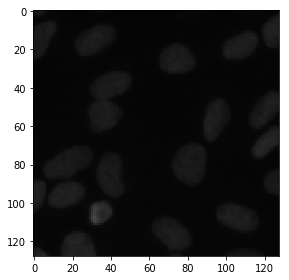

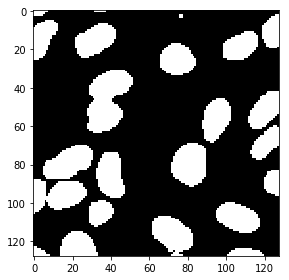

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Creating Keras metric

* Defining the mean average precision at different intersection over union (IoU) thresholds metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds.

* This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ...

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Building and Training the Neural Network

In [6]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Fitting the model on the training data, using a validation split of 0.1.

In [7]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/30
603/603 [==============================] - ETA: 2:48 - loss: 0.6930 - mean_iou: 0.0000e+ - ETA: 1:25 - loss: 0.6843 - mean_iou: 0.2126   - ETA: 58s - loss: 0.6803 - mean_iou: 0.2823 - ETA: 44s - loss: 0.6790 - mean_iou: 0.319 - ETA: 36s - loss: 0.6740 - mean_iou: 0.341 - ETA: 30s - loss: 0.6735 - mean_iou: 0.356 - ETA: 26s - loss: 0.6676 - mean_iou: 0.366 - ETA: 23s - loss: 0.6643 - mean_iou: 0.374 - ETA: 21s - loss: 0.6638 - mean_iou: 0.381 - ETA: 19s - loss: 0.6581 - mean_iou: 0.385 - ETA: 17s - loss: 0.6542 - mean_iou: 0.389 - ETA: 16s - loss: 0.6450 - mean_iou: 0.392 - ETA: 15s - loss: 0.6392 - mean_iou: 0.395 - ETA: 14s - loss: 0.6313 - mean_iou: 0.397 - ETA: 13s - loss: 0.6272 - mean_iou: 0.399 - ETA: 12s - loss: 0.6197 - mean_iou: 0.400 - ETA: 11s - loss: 0.6134 - mean_iou: 0.402 - ETA: 11s - loss: 0.6032 - mean_iou: 0.403 - ETA: 10s - loss: 0.5983 - mean_iou: 0.404 - ETA: 10s - loss: 0.5922 - mean_iou: 0.405 - ETA: 9s - lo

603/603 [==============================] - ETA: 5s - loss: 0.2372 - mean_iou: 0.42 - ETA: 5s - loss: 0.2386 - mean_iou: 0.42 - ETA: 5s - loss: 0.2294 - mean_iou: 0.42 - ETA: 5s - loss: 0.2157 - mean_iou: 0.42 - ETA: 5s - loss: 0.2117 - mean_iou: 0.42 - ETA: 5s - loss: 0.2088 - mean_iou: 0.42 - ETA: 5s - loss: 0.2212 - mean_iou: 0.42 - ETA: 5s - loss: 0.2235 - mean_iou: 0.42 - ETA: 5s - loss: 0.2155 - mean_iou: 0.42 - ETA: 5s - loss: 0.2190 - mean_iou: 0.42 - ETA: 4s - loss: 0.2171 - mean_iou: 0.42 - ETA: 4s - loss: 0.2112 - mean_iou: 0.42 - ETA: 4s - loss: 0.2138 - mean_iou: 0.42 - ETA: 4s - loss: 0.2130 - mean_iou: 0.42 - ETA: 4s - loss: 0.2168 - mean_iou: 0.42 - ETA: 4s - loss: 0.2130 - mean_iou: 0.42 - ETA: 4s - loss: 0.2162 - mean_iou: 0.42 - ETA: 4s - loss: 0.2163 - mean_iou: 0.42 - ETA: 4s - loss: 0.2144 - mean_iou: 0.42 - ETA: 4s - loss: 0.2125 - mean_iou: 0.42 - ETA: 4s - loss: 0.2090 - mean_iou: 0.42 - ETA: 4s - loss: 0.2071 - mean_iou: 0.42 - ETA: 4s - loss: 0.2070 - mean_iou

603/603 [==============================] - ETA: 4s - loss: 0.1458 - mean_iou: 0.52 - ETA: 5s - loss: 0.1483 - mean_iou: 0.52 - ETA: 4s - loss: 0.1308 - mean_iou: 0.53 - ETA: 5s - loss: 0.1320 - mean_iou: 0.53 - ETA: 5s - loss: 0.1333 - mean_iou: 0.53 - ETA: 5s - loss: 0.1333 - mean_iou: 0.53 - ETA: 5s - loss: 0.1355 - mean_iou: 0.53 - ETA: 5s - loss: 0.1502 - mean_iou: 0.53 - ETA: 4s - loss: 0.1433 - mean_iou: 0.53 - ETA: 4s - loss: 0.1392 - mean_iou: 0.53 - ETA: 4s - loss: 0.1466 - mean_iou: 0.53 - ETA: 4s - loss: 0.1505 - mean_iou: 0.53 - ETA: 4s - loss: 0.1514 - mean_iou: 0.53 - ETA: 4s - loss: 0.1531 - mean_iou: 0.53 - ETA: 4s - loss: 0.1492 - mean_iou: 0.53 - ETA: 4s - loss: 0.1519 - mean_iou: 0.53 - ETA: 4s - loss: 0.1515 - mean_iou: 0.53 - ETA: 4s - loss: 0.1525 - mean_iou: 0.53 - ETA: 4s - loss: 0.1529 - mean_iou: 0.53 - ETA: 4s - loss: 0.1540 - mean_iou: 0.53 - ETA: 4s - loss: 0.1507 - mean_iou: 0.53 - ETA: 4s - loss: 0.1490 - mean_iou: 0.53 - ETA: 3s - loss: 0.1463 - mean_iou

603/603 [==============================] - ETA: 4s - loss: 0.0844 - mean_iou: 0.61 - ETA: 5s - loss: 0.0840 - mean_iou: 0.61 - ETA: 5s - loss: 0.0800 - mean_iou: 0.61 - ETA: 5s - loss: 0.0861 - mean_iou: 0.61 - ETA: 5s - loss: 0.0886 - mean_iou: 0.61 - ETA: 5s - loss: 0.0849 - mean_iou: 0.61 - ETA: 5s - loss: 0.0815 - mean_iou: 0.61 - ETA: 5s - loss: 0.0803 - mean_iou: 0.61 - ETA: 4s - loss: 0.0926 - mean_iou: 0.61 - ETA: 4s - loss: 0.0933 - mean_iou: 0.61 - ETA: 4s - loss: 0.0939 - mean_iou: 0.61 - ETA: 4s - loss: 0.0943 - mean_iou: 0.61 - ETA: 4s - loss: 0.0937 - mean_iou: 0.61 - ETA: 4s - loss: 0.0922 - mean_iou: 0.61 - ETA: 4s - loss: 0.0941 - mean_iou: 0.61 - ETA: 4s - loss: 0.0989 - mean_iou: 0.61 - ETA: 4s - loss: 0.0988 - mean_iou: 0.61 - ETA: 4s - loss: 0.0973 - mean_iou: 0.61 - ETA: 4s - loss: 0.1016 - mean_iou: 0.61 - ETA: 4s - loss: 0.1023 - mean_iou: 0.61 - ETA: 4s - loss: 0.1014 - mean_iou: 0.61 - ETA: 3s - loss: 0.1020 - mean_iou: 0.61 - ETA: 3s - loss: 0.1017 - mean_iou

603/603 [==============================] - ETA: 5s - loss: 0.0705 - mean_iou: 0.66 - ETA: 5s - loss: 0.0808 - mean_iou: 0.66 - ETA: 5s - loss: 0.0704 - mean_iou: 0.66 - ETA: 5s - loss: 0.0628 - mean_iou: 0.66 - ETA: 5s - loss: 0.0693 - mean_iou: 0.66 - ETA: 5s - loss: 0.0710 - mean_iou: 0.66 - ETA: 5s - loss: 0.0740 - mean_iou: 0.66 - ETA: 5s - loss: 0.0749 - mean_iou: 0.66 - ETA: 4s - loss: 0.0759 - mean_iou: 0.66 - ETA: 4s - loss: 0.0783 - mean_iou: 0.66 - ETA: 4s - loss: 0.0782 - mean_iou: 0.66 - ETA: 4s - loss: 0.0813 - mean_iou: 0.66 - ETA: 4s - loss: 0.0817 - mean_iou: 0.66 - ETA: 4s - loss: 0.0826 - mean_iou: 0.66 - ETA: 4s - loss: 0.0815 - mean_iou: 0.66 - ETA: 4s - loss: 0.0857 - mean_iou: 0.66 - ETA: 4s - loss: 0.0844 - mean_iou: 0.66 - ETA: 4s - loss: 0.0870 - mean_iou: 0.66 - ETA: 4s - loss: 0.0890 - mean_iou: 0.66 - ETA: 4s - loss: 0.0877 - mean_iou: 0.66 - ETA: 4s - loss: 0.0871 - mean_iou: 0.66 - ETA: 4s - loss: 0.0887 - mean_iou: 0.66 - ETA: 3s - loss: 0.0907 - mean_iou

603/603 [==============================] - ETA: 5s - loss: 0.1500 - mean_iou: 0.69 - ETA: 5s - loss: 0.1256 - mean_iou: 0.69 - ETA: 5s - loss: 0.1205 - mean_iou: 0.69 - ETA: 5s - loss: 0.1192 - mean_iou: 0.69 - ETA: 5s - loss: 0.1056 - mean_iou: 0.69 - ETA: 5s - loss: 0.0939 - mean_iou: 0.69 - ETA: 5s - loss: 0.0967 - mean_iou: 0.69 - ETA: 4s - loss: 0.1065 - mean_iou: 0.69 - ETA: 4s - loss: 0.1075 - mean_iou: 0.69 - ETA: 4s - loss: 0.1057 - mean_iou: 0.69 - ETA: 4s - loss: 0.1047 - mean_iou: 0.69 - ETA: 4s - loss: 0.1045 - mean_iou: 0.69 - ETA: 4s - loss: 0.1057 - mean_iou: 0.69 - ETA: 4s - loss: 0.1018 - mean_iou: 0.69 - ETA: 4s - loss: 0.1006 - mean_iou: 0.69 - ETA: 4s - loss: 0.0980 - mean_iou: 0.69 - ETA: 4s - loss: 0.0957 - mean_iou: 0.69 - ETA: 4s - loss: 0.0954 - mean_iou: 0.69 - ETA: 4s - loss: 0.0932 - mean_iou: 0.69 - ETA: 4s - loss: 0.0914 - mean_iou: 0.69 - ETA: 4s - loss: 0.0914 - mean_iou: 0.69 - ETA: 4s - loss: 0.0907 - mean_iou: 0.69 - ETA: 3s - loss: 0.0915 - mean_iou

603/603 [==============================] - ETA: 6s - loss: 0.0886 - mean_iou: 0.71 - ETA: 6s - loss: 0.0732 - mean_iou: 0.71 - ETA: 5s - loss: 0.0774 - mean_iou: 0.71 - ETA: 5s - loss: 0.0945 - mean_iou: 0.71 - ETA: 5s - loss: 0.0860 - mean_iou: 0.71 - ETA: 5s - loss: 0.0898 - mean_iou: 0.71 - ETA: 5s - loss: 0.0930 - mean_iou: 0.71 - ETA: 5s - loss: 0.0900 - mean_iou: 0.71 - ETA: 4s - loss: 0.0950 - mean_iou: 0.71 - ETA: 4s - loss: 0.0934 - mean_iou: 0.71 - ETA: 4s - loss: 0.0894 - mean_iou: 0.71 - ETA: 4s - loss: 0.0906 - mean_iou: 0.71 - ETA: 4s - loss: 0.0884 - mean_iou: 0.71 - ETA: 4s - loss: 0.0888 - mean_iou: 0.71 - ETA: 4s - loss: 0.0876 - mean_iou: 0.71 - ETA: 4s - loss: 0.0864 - mean_iou: 0.71 - ETA: 4s - loss: 0.0854 - mean_iou: 0.71 - ETA: 4s - loss: 0.0834 - mean_iou: 0.71 - ETA: 4s - loss: 0.0870 - mean_iou: 0.71 - ETA: 4s - loss: 0.0873 - mean_iou: 0.71 - ETA: 4s - loss: 0.0894 - mean_iou: 0.71 - ETA: 4s - loss: 0.0887 - mean_iou: 0.71 - ETA: 4s - loss: 0.0873 - mean_iou

603/603 [==============================] - ETA: 6s - loss: 0.0700 - mean_iou: 0.73 - ETA: 5s - loss: 0.1101 - mean_iou: 0.73 - ETA: 5s - loss: 0.1035 - mean_iou: 0.73 - ETA: 5s - loss: 0.0871 - mean_iou: 0.73 - ETA: 5s - loss: 0.0872 - mean_iou: 0.73 - ETA: 5s - loss: 0.0852 - mean_iou: 0.73 - ETA: 5s - loss: 0.0837 - mean_iou: 0.73 - ETA: 5s - loss: 0.0926 - mean_iou: 0.73 - ETA: 5s - loss: 0.0977 - mean_iou: 0.73 - ETA: 5s - loss: 0.0973 - mean_iou: 0.73 - ETA: 4s - loss: 0.0990 - mean_iou: 0.73 - ETA: 4s - loss: 0.0961 - mean_iou: 0.73 - ETA: 4s - loss: 0.0966 - mean_iou: 0.73 - ETA: 4s - loss: 0.0966 - mean_iou: 0.73 - ETA: 4s - loss: 0.0958 - mean_iou: 0.73 - ETA: 4s - loss: 0.0982 - mean_iou: 0.73 - ETA: 4s - loss: 0.0954 - mean_iou: 0.73 - ETA: 4s - loss: 0.0937 - mean_iou: 0.73 - ETA: 4s - loss: 0.0933 - mean_iou: 0.73 - ETA: 4s - loss: 0.0940 - mean_iou: 0.73 - ETA: 4s - loss: 0.0946 - mean_iou: 0.73 - ETA: 4s - loss: 0.0915 - mean_iou: 0.73 - ETA: 3s - loss: 0.0910 - mean_iou

603/603 [==============================] - ETA: 5s - loss: 0.0622 - mean_iou: 0.74 - ETA: 5s - loss: 0.0500 - mean_iou: 0.74 - ETA: 5s - loss: 0.0554 - mean_iou: 0.74 - ETA: 5s - loss: 0.0613 - mean_iou: 0.74 - ETA: 5s - loss: 0.0595 - mean_iou: 0.74 - ETA: 5s - loss: 0.0586 - mean_iou: 0.74 - ETA: 5s - loss: 0.0601 - mean_iou: 0.75 - ETA: 5s - loss: 0.0699 - mean_iou: 0.75 - ETA: 5s - loss: 0.0684 - mean_iou: 0.75 - ETA: 5s - loss: 0.0684 - mean_iou: 0.75 - ETA: 4s - loss: 0.0701 - mean_iou: 0.75 - ETA: 4s - loss: 0.0749 - mean_iou: 0.75 - ETA: 4s - loss: 0.0745 - mean_iou: 0.75 - ETA: 4s - loss: 0.0744 - mean_iou: 0.75 - ETA: 4s - loss: 0.0769 - mean_iou: 0.75 - ETA: 4s - loss: 0.0772 - mean_iou: 0.75 - ETA: 4s - loss: 0.0771 - mean_iou: 0.75 - ETA: 4s - loss: 0.0757 - mean_iou: 0.75 - ETA: 4s - loss: 0.0758 - mean_iou: 0.75 - ETA: 4s - loss: 0.0756 - mean_iou: 0.75 - ETA: 4s - loss: 0.0766 - mean_iou: 0.75 - ETA: 4s - loss: 0.0766 - mean_iou: 0.75 - ETA: 3s - loss: 0.0757 - mean_iou

603/603 [==============================] - ETA: 5s - loss: 0.1083 - mean_iou: 0.76 - ETA: 5s - loss: 0.0838 - mean_iou: 0.76 - ETA: 5s - loss: 0.0736 - mean_iou: 0.76 - ETA: 5s - loss: 0.0732 - mean_iou: 0.76 - ETA: 5s - loss: 0.0831 - mean_iou: 0.76 - ETA: 4s - loss: 0.0834 - mean_iou: 0.76 - ETA: 4s - loss: 0.0863 - mean_iou: 0.76 - ETA: 4s - loss: 0.0917 - mean_iou: 0.76 - ETA: 4s - loss: 0.0880 - mean_iou: 0.76 - ETA: 4s - loss: 0.0944 - mean_iou: 0.76 - ETA: 4s - loss: 0.0950 - mean_iou: 0.76 - ETA: 4s - loss: 0.0930 - mean_iou: 0.76 - ETA: 4s - loss: 0.0942 - mean_iou: 0.76 - ETA: 4s - loss: 0.0926 - mean_iou: 0.76 - ETA: 4s - loss: 0.0915 - mean_iou: 0.76 - ETA: 4s - loss: 0.0938 - mean_iou: 0.76 - ETA: 4s - loss: 0.0923 - mean_iou: 0.76 - ETA: 4s - loss: 0.0975 - mean_iou: 0.76 - ETA: 4s - loss: 0.0956 - mean_iou: 0.76 - ETA: 4s - loss: 0.0933 - mean_iou: 0.76 - ETA: 4s - loss: 0.0908 - mean_iou: 0.76 - ETA: 4s - loss: 0.0917 - mean_iou: 0.76 - ETA: 3s - loss: 0.0921 - mean_iou

603/603 [==============================] - ETA: 5s - loss: 0.0360 - mean_iou: 0.77 - ETA: 5s - loss: 0.0619 - mean_iou: 0.77 - ETA: 5s - loss: 0.0603 - mean_iou: 0.77 - ETA: 5s - loss: 0.0689 - mean_iou: 0.77 - ETA: 5s - loss: 0.0748 - mean_iou: 0.77 - ETA: 5s - loss: 0.0751 - mean_iou: 0.77 - ETA: 5s - loss: 0.0760 - mean_iou: 0.77 - ETA: 5s - loss: 0.0764 - mean_iou: 0.77 - ETA: 4s - loss: 0.0736 - mean_iou: 0.77 - ETA: 4s - loss: 0.0772 - mean_iou: 0.77 - ETA: 4s - loss: 0.0810 - mean_iou: 0.77 - ETA: 4s - loss: 0.0820 - mean_iou: 0.77 - ETA: 4s - loss: 0.0811 - mean_iou: 0.77 - ETA: 4s - loss: 0.0824 - mean_iou: 0.77 - ETA: 4s - loss: 0.0813 - mean_iou: 0.77 - ETA: 4s - loss: 0.0817 - mean_iou: 0.77 - ETA: 4s - loss: 0.0792 - mean_iou: 0.77 - ETA: 4s - loss: 0.0823 - mean_iou: 0.77 - ETA: 4s - loss: 0.0796 - mean_iou: 0.77 - ETA: 4s - loss: 0.0781 - mean_iou: 0.77 - ETA: 4s - loss: 0.0771 - mean_iou: 0.77 - ETA: 4s - loss: 0.0785 - mean_iou: 0.77 - ETA: 3s - loss: 0.0779 - mean_iou

603/603 [==============================] - ETA: 5s - loss: 0.0582 - mean_iou: 0.77 - ETA: 5s - loss: 0.0936 - mean_iou: 0.77 - ETA: 5s - loss: 0.1051 - mean_iou: 0.77 - ETA: 5s - loss: 0.1012 - mean_iou: 0.77 - ETA: 5s - loss: 0.0934 - mean_iou: 0.77 - ETA: 5s - loss: 0.0964 - mean_iou: 0.77 - ETA: 5s - loss: 0.0863 - mean_iou: 0.77 - ETA: 5s - loss: 0.0900 - mean_iou: 0.77 - ETA: 4s - loss: 0.0890 - mean_iou: 0.77 - ETA: 4s - loss: 0.0864 - mean_iou: 0.77 - ETA: 4s - loss: 0.0848 - mean_iou: 0.77 - ETA: 4s - loss: 0.0825 - mean_iou: 0.77 - ETA: 4s - loss: 0.0814 - mean_iou: 0.77 - ETA: 4s - loss: 0.0807 - mean_iou: 0.77 - ETA: 4s - loss: 0.0794 - mean_iou: 0.77 - ETA: 4s - loss: 0.0800 - mean_iou: 0.77 - ETA: 4s - loss: 0.0797 - mean_iou: 0.77 - ETA: 4s - loss: 0.0778 - mean_iou: 0.77 - ETA: 4s - loss: 0.0801 - mean_iou: 0.77 - ETA: 4s - loss: 0.0801 - mean_iou: 0.77 - ETA: 4s - loss: 0.0793 - mean_iou: 0.77 - ETA: 3s - loss: 0.0813 - mean_iou: 0.77 - ETA: 3s - loss: 0.0800 - mean_iou

603/603 [==============================] - ETA: 5s - loss: 0.0505 - mean_iou: 0.78 - ETA: 5s - loss: 0.0674 - mean_iou: 0.78 - ETA: 5s - loss: 0.1022 - mean_iou: 0.78 - ETA: 5s - loss: 0.0859 - mean_iou: 0.78 - ETA: 5s - loss: 0.0860 - mean_iou: 0.78 - ETA: 5s - loss: 0.0851 - mean_iou: 0.78 - ETA: 5s - loss: 0.0851 - mean_iou: 0.78 - ETA: 5s - loss: 0.0817 - mean_iou: 0.78 - ETA: 5s - loss: 0.0810 - mean_iou: 0.78 - ETA: 5s - loss: 0.0876 - mean_iou: 0.78 - ETA: 4s - loss: 0.0850 - mean_iou: 0.78 - ETA: 4s - loss: 0.0849 - mean_iou: 0.78 - ETA: 4s - loss: 0.0827 - mean_iou: 0.78 - ETA: 4s - loss: 0.0883 - mean_iou: 0.78 - ETA: 4s - loss: 0.0881 - mean_iou: 0.78 - ETA: 4s - loss: 0.0846 - mean_iou: 0.78 - ETA: 4s - loss: 0.0820 - mean_iou: 0.78 - ETA: 4s - loss: 0.0818 - mean_iou: 0.78 - ETA: 4s - loss: 0.0839 - mean_iou: 0.78 - ETA: 4s - loss: 0.0831 - mean_iou: 0.78 - ETA: 4s - loss: 0.0823 - mean_iou: 0.78 - ETA: 4s - loss: 0.0828 - mean_iou: 0.78 - ETA: 3s - loss: 0.0812 - mean_iou

603/603 [==============================] - ETA: 6s - loss: 0.0920 - mean_iou: 0.79 - ETA: 6s - loss: 0.0785 - mean_iou: 0.79 - ETA: 6s - loss: 0.0813 - mean_iou: 0.79 - ETA: 5s - loss: 0.0743 - mean_iou: 0.79 - ETA: 5s - loss: 0.0750 - mean_iou: 0.79 - ETA: 5s - loss: 0.0695 - mean_iou: 0.79 - ETA: 5s - loss: 0.0715 - mean_iou: 0.79 - ETA: 5s - loss: 0.0676 - mean_iou: 0.79 - ETA: 5s - loss: 0.0720 - mean_iou: 0.79 - ETA: 5s - loss: 0.0775 - mean_iou: 0.79 - ETA: 5s - loss: 0.0762 - mean_iou: 0.79 - ETA: 4s - loss: 0.0779 - mean_iou: 0.79 - ETA: 4s - loss: 0.0813 - mean_iou: 0.79 - ETA: 4s - loss: 0.0816 - mean_iou: 0.79 - ETA: 4s - loss: 0.0792 - mean_iou: 0.79 - ETA: 4s - loss: 0.0825 - mean_iou: 0.79 - ETA: 4s - loss: 0.0813 - mean_iou: 0.79 - ETA: 4s - loss: 0.0800 - mean_iou: 0.79 - ETA: 4s - loss: 0.0798 - mean_iou: 0.79 - ETA: 4s - loss: 0.0800 - mean_iou: 0.79 - ETA: 4s - loss: 0.0802 - mean_iou: 0.79 - ETA: 4s - loss: 0.0796 - mean_iou: 0.79 - ETA: 4s - loss: 0.0798 - mean_iou

603/603 [==============================] - ETA: 4s - loss: 0.0690 - mean_iou: 0.79 - ETA: 5s - loss: 0.0723 - mean_iou: 0.79 - ETA: 5s - loss: 0.0692 - mean_iou: 0.79 - ETA: 5s - loss: 0.0820 - mean_iou: 0.79 - ETA: 5s - loss: 0.0830 - mean_iou: 0.79 - ETA: 5s - loss: 0.0767 - mean_iou: 0.79 - ETA: 5s - loss: 0.0762 - mean_iou: 0.79 - ETA: 5s - loss: 0.0772 - mean_iou: 0.79 - ETA: 5s - loss: 0.0740 - mean_iou: 0.79 - ETA: 5s - loss: 0.0783 - mean_iou: 0.79 - ETA: 5s - loss: 0.0743 - mean_iou: 0.79 - ETA: 4s - loss: 0.0728 - mean_iou: 0.79 - ETA: 4s - loss: 0.0719 - mean_iou: 0.79 - ETA: 4s - loss: 0.0729 - mean_iou: 0.79 - ETA: 4s - loss: 0.0722 - mean_iou: 0.79 - ETA: 4s - loss: 0.0742 - mean_iou: 0.79 - ETA: 4s - loss: 0.0751 - mean_iou: 0.79 - ETA: 4s - loss: 0.0733 - mean_iou: 0.79 - ETA: 4s - loss: 0.0729 - mean_iou: 0.79 - ETA: 4s - loss: 0.0730 - mean_iou: 0.79 - ETA: 4s - loss: 0.0715 - mean_iou: 0.79 - ETA: 4s - loss: 0.0719 - mean_iou: 0.79 - ETA: 4s - loss: 0.0726 - mean_iou

# Making predictions

In [8]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test_1 = model.predict(X_test_1, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_1_t = (preds_test_1 > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_1_upsampled = []
for i in range(len(preds_test_1)):
    preds_test_1_upsampled.append(resize(np.squeeze(preds_test_1[i]), 
                                       (sizes_test_1[i][0], sizes_test_1[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - 0s 2ms/step


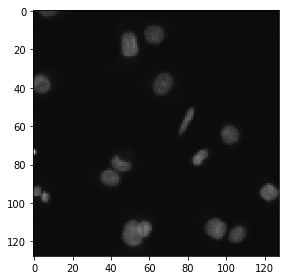

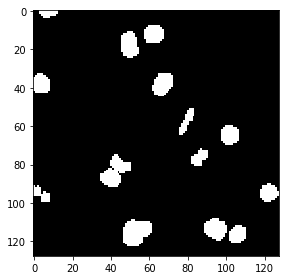

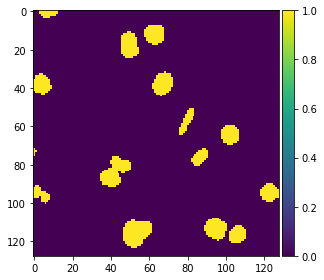

In [9]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

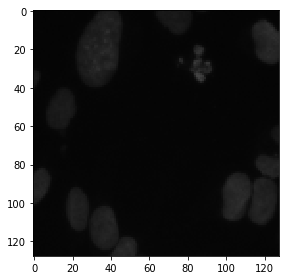

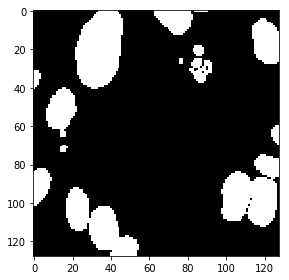

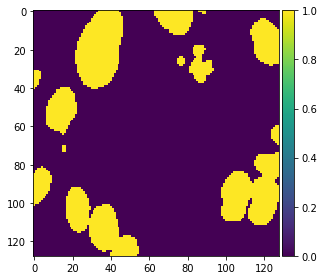

In [10]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Encoding and readying the submission file

In [11]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Iterating over the test IDs and generating run-length encodings for each seperate mask identified by skimage ...

In [12]:
new_test_1_ids = []
rles = []
for n, id_ in enumerate(test_ids_1):
    rle = list(prob_to_rles(preds_test_1_upsampled[n]))
    rles.extend(rle)
    new_test_1_ids.extend([id_] * len(rle))

... and then finally creating the submission!

In [13]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_1_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../../sub-dsbowl2018-1.csv', index=False)